# Overview of this Notebook

This notebook plots the feature images associated with a given subject, block, and trial on respective AOIs.

In [3]:
%load_ext autoreload
%autoreload

In [4]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as matplotlib
from matplotlib.colors import ListedColormap
import seaborn as sns
import scipy.io as io
import pandas as pd
from pandas import DataFrame, read_csv
from nivlink import Screen, Raw, Epochs, align_to_aoi, compute_fixations, plot_heatmaps
import cv2
import readline
from math import dist
from scipy.spatial.distance import squareform, pdist

import warnings
from scipy.stats import kde
import nivlink
import ipywidgets as wdg
from scipy.stats import iqr
print('Powered by NivLink' + str(nivlink.__version__))

import plotAOIFeatures as paf

Powered by NivLink0.2.5
Powered by NivLink0.2.5


In [8]:
## Define global variables ##
et_data_dir = os.getcwd().strip('ldm-analysis') + 'ProcessedData/'# this expects ProcessedData to be one directory up from the analysis repo
image_dir = os.getcwd().strip('ldm-analysis') + 'FinalStimuli/ByNumber/'

## Define screen metadata.
xdim, ydim, n_screens = 1280, 1024, 1 
aoisidelength = 162
n_aois = 9

In [128]:
subj_id = 39
block = 10
trial = 1
n_trials_block = 40
## Load data.
data, raw_pos_data, messages, sfreq = paf.load_subj_data(subj_id)

## Load all centers.
all_centers = pd.read_csv(os.getcwd() + '/allCenters.csv')

## Subset this participant's centers. 
sub = 'Sub' + str(subj_id) + '_'
centers = all_centers[all_centers['Unnamed: 0'].str.contains(sub)]
centers['Block'] = [int(s.replace(sub + 'block' + '_', "")) for s in list(centers['Unnamed: 0'].values)]

## Mark run onsets. 
run_onsets = paf.get_run_onsets(messages)
n_blocks, d = run_onsets.shape
print(n_blocks)

# Load feature map
featmap_file_path = et_data_dir + str(subj_id) + 'featmap.mat'
featmap_mat = io.loadmat(featmap_file_path, struct_as_record=False, squeeze_me=True)
featmap = np.array(featmap_mat["features_aoi_map"])

# Re-format events dataframe. 
events_df = paf.rereference_events(subj_id, n_blocks, run_onsets, sfreq)

# Load fixations for sub
fixations = pd.read_csv(et_data_dir + str(subj_id) + 'fixations.csv')
fixations = fixations.rename(columns={'Unnamed: 0': 'WithinBlockCount'})
# split the fixations df based on block to get a list of indices when the block number changes
grouped = fixations.groupby(fixations.WithinBlockCount)
df_getindexes = grouped.get_group(0)
index_start_list = df_getindexes.index.values.tolist()
index_start_list.append(fixations.shape[0])
if index_start_list[0] != 0:
    index_start_list.insert(0, 0)
print(index_start_list)
# use list of indices to make a new column
new_col = np.ones((fixations.shape[0])).astype(int)
# subj 39, block 4 is empty
if subj_id == 39:
    for block_num in np.arange(3):
        new_col[index_start_list[block_num]:index_start_list[block_num+1]] = new_col[index_start_list[block_num]:index_start_list[block_num+1]]*(block_num+1)
    for block_num in np.arange(4,n_blocks):
        new_col[index_start_list[block_num-1]:index_start_list[block_num]] = new_col[index_start_list[block_num-1]:index_start_list[block_num]]*(block_num+1)
else: 
    for block_num in np.arange(n_blocks):
        new_col[index_start_list[block_num]:index_start_list[block_num+1]] = new_col[index_start_list[block_num]:index_start_list[block_num+1]]*(block_num+1)
fixations['BlockNumber'] = new_col

10
[0, 629, 1462, 2254, 2794, 3488, 4212, 5013, 5660, 5930]


/var/folders/wg/m30l6kjs09l1pxs4fshqx1xxjyhc2c/T/ipykernel_7563/707487155.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centers['Block'] = [int(s.replace(sub + 'block' + '_', "")) for s in list(centers['Unnamed: 0'].values)]


In [129]:
fixations_block = fixations[fixations.BlockNumber == block]
fixations_block_trial = fixations_block[fixations_block.Trial == (block-1)*n_trials_block + trial]

In [130]:
fixations_block_trial

,WithinBlockCount,Trial,AoI,Onset,Offset,Duration,Feature,BlockNumber
5660,0,361.0,5.0,0.040,0.068,0.028,8.0,10
5661,2,361.0,4.0,0.076,0.232,0.156,3.0,10
5662,4,361.0,1.0,0.240,0.244,0.004,2.0,10
5663,5,361.0,10.0,0.248,0.252,0.004,10.0,10
5664,6,361.0,2.0,0.256,1.032,0.776,9.0,10
5665,7,361.0,1.0,1.304,2.348,1.044,2.0,10
5666,9,361.0,2.0,2.356,2.384,0.028,9.0,10
5667,10,361.0,10.0,2.388,2.512,0.124,10.0,10
5668,11,361.0,2.0,2.516,3.124,0.608,9.0,10
5669,12,361.0,10.0,3.128,3.140,0.012,10.0,10


      Unnamed: 0  Trial   AoI  Onset  Offset  Duration  Feature
0              0    1.0  10.0  0.000   0.008     0.008     10.0
1              1    1.0   4.0  0.012   0.044     0.032      2.0
2              3    1.0   5.0  0.052   0.120     0.068      9.0
3              4    1.0   4.0  0.124   0.152     0.028      2.0
4              5    1.0  10.0  0.156   0.160     0.004     10.0
...          ...    ...   ...    ...     ...       ...      ...
5925         342  396.0   6.0  2.172   2.180     0.008      5.0
5926         343  396.0  10.0  2.184   2.232     0.048     10.0
5927         344  400.0   8.0  3.708   3.848     0.140      7.0
5928         345  400.0  10.0  3.852   3.856     0.004     10.0
5929         346  400.0   5.0  3.860   4.012     0.152      8.0

[5930 rows x 7 columns]
40


/Users/nsb373/Documents/EyetrackingProject/ldm-analysis/plotAOIFeatures.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centers['Block'] = [int(s.replace(sub + 'block' + '_', "")) for s in list(centers['Unnamed: 0'].values)]


(<Figure size 270x216 with 2 Axes>, <AxesSubplot:>)

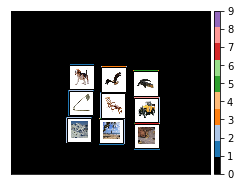

In [5]:
paf.plotAOIFeatures(39, 1, 3)